# Time Series Classification with sktime

The Time Series Classification (TSC) task involves training a model from a collection
 of time series (real valued, ordered, data) in order to predict a target variable.
 For example, we might want to build a model that can predict whether a patient
 issick based on their ECG reading, or predict whether a device will fail based on
 some sensor reading. This notebook gives a quick guide to TSC get you started.

<img src="./img/tsc.png" width="600" alt="time series classification"> [<i>&#x200B;</i>](./img/tsc.png)

## Data Storage and Problem Types

Time series can be univariate (each observation is a single valued) or multivariate
(each observation is a vector). For example, an outline of an image univariate
series, but a motion trace of a tennis player would be multivariate, with three
dimensions (x,y,z co-ordinates). The image above is a univariate problem: each series
 has its own label. The dimension of the time series instance is also often called the
 channel. We recommend storing time series in 3D numpy array of shape (instance,
 dimension, time point) and where possible our single problem loaders will return a
 3D numpy

In [4]:
# Plotting and data loading imports used in this notebook
import matplotlib.pyplot as plt

from sktime.datasets import load_arrow_head, load_basic_motions

# ArrowHead data of shape (X,1,X) and BasicMotions of shape (X,3,X)
arrow, arrow_labels = load_arrow_head(split="train")
motions, motions_labels = load_basic_motions(split="train")
print(f"ArrowHead series of type {type(arrow)} and shape {arrow.shape}")
print(f"Motions type {type(motions)} of shape {motions_labels.shape}")

ModuleNotFoundError: No module named 'sktime'

We tend to use 3D numpy even if the data is univariate, although all classifiers work
 with shape (instance, time point), currently some transformers do not work correctly
  with 2D arrays. If your series are unequal length, have missing values or are
  sampled at irregular time intervals, you should read the note book
  datatypes_and_datasets (link).

The UCR/UEA [TSC dataset archive](https://timeseriesclassification.com/) contains a large number of example TSC problems that have been used thousands of times in the literature to assess TSC algorithms. These datasets have certain characteristics that influence what data structure we use to store them in memory.

Most datasets in the archive contain time series all the same length. For example,
the [ArrowHead dataset](https://timeseriesclassification.com/description
.php?Dataset=ArrowHead) we have just loaded consists of outlines of the images of arrow
heads. The classification of projectile points is an important topic in anthropology.

<img src="./img/arrow-heads.png" width="600" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="600" alt="from shapes to time series">

Each instance consists of a single time series (i.e. the problem is univariate) of equal length and a class label based on shape distinctions such as the presence and location of a notch in the arrow. The data set consists of 210 instances, by default split into 36 train and 175 test instances.

The [BasicMotions dataset](https://timeseriesclassification.com/description
.php?Dataset=BasicMotions) is an example of a multivariate TSC problem. It was generated
 as part of a project where four students performed four activities whilst wearing a
 smartwatch. The watch collects 3D accelerometer and 3D gyroscope data. Each instance
  involved a subject performing one of four tasks (walking, resting, running and
  badminton) for ten seconds. Time series in this data set have six dimensions or
  channels.

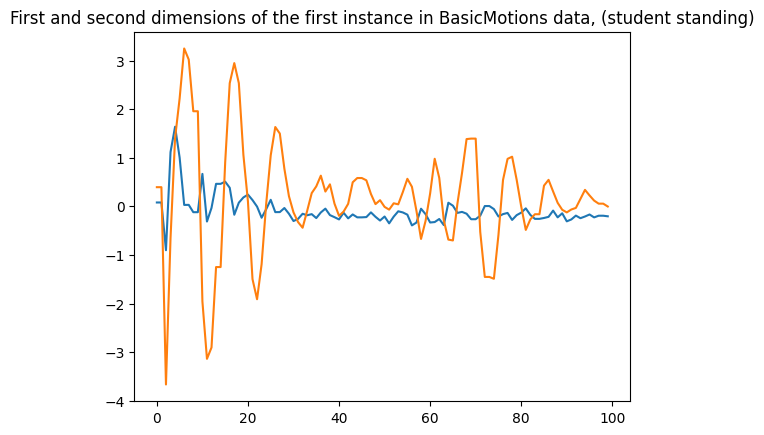

In [9]:
plt.title(
    f"First and second dimensions of the first instance in BasicMotions data, "
    f"(student {motions_labels[0]})"
)
plt.plot(motions[0][0])
plt.plot(motions[0][1])

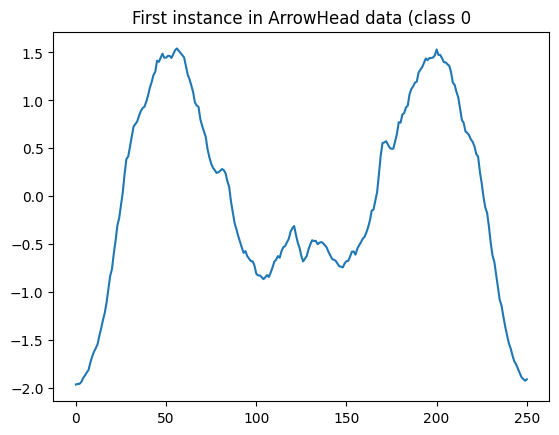

In [10]:
plt.title(f"First instance in ArrowHead data (class {arrow_labels[0]})")
plt.plot(arrow[0, 0])

It is possible to use a standard `sklearn` classifier for univariate, equal length
classification problems, but it is unlikely to perform as well as bespoke time series classifiers, since `sklearn` classifiers ignore the sequence information in the variables.

To apply `sklearn` classifiers directly, the data needs to be reshaped into a 2D
numpy array. We also offer the ability to load univariate TSC problems directly in 2D
 arrays. Please note that currently, due to poor legacy design decisions, Transformers
  do not work correctly  with 2D numpy classification problems, so we recommend using
   3D numpy.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(n_estimators=100)
arrow2d = arrow.squeeze()
arrow_test, arrow_test_labels = load_arrow_head(split="test", return_type="numpy2d")
classifier.fit(arrow2d, arrow_labels)
y_pred = classifier.predict(arrow_test)
accuracy_score(arrow_test_labels, y_pred)

To use `sklearn` classifiers directly on multivariate data, one option is to flatten
the data so that (instances, dimensions, length) becomes (instances, dimensions*length).

In [ ]:
motions_test, motions_test_labels = load_basic_motions(split="test")
motions2d = motions.reshape(motions.shape[0], motions.shape[1] * motions.shape[2])
motions2d_test = motions_test.reshape(
    motions_test.shape[0], motions_test.shape[1] * motions_test.shape[2]
)
classifier.fit(motions2d, motions_labels)
y_pred = classifier.predict(motions2d_test)
accuracy_score(motions_test_labels, y_pred)

## Time Series Classifiers in scikit-time

`sktime` contains the state of the art in time series classifiers in the package
classification. These are grouped based on the
data representation used to find discriminatory features. We provide a separate
notebook for each of these (LINK HERE). An accurate and relatively
fast classifier is the [ROCKET](https://link.springer.com/article/10.1007/s10618-020-00701-z) algorithm:

We show the simplest use cases for classifiers and demonstrate how to build bespoke pipelines for time series classification.

In [ ]:
from sktime.classification.convolution_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2000)
rocket.fit(arrow, arrow_labels)
y_pred = rocket.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

Another accurate classifier for time series classification is version 2 of the
[HIVE-COTE](https://link.springer.com/article/10.1007/s10994-021-06057-9) algorithm.
(HC2).
HC2 is relatively slow on small problems like these examples. However, it can be
configured with an approximate maximum run time as follows (it may take a bit longer
than 12 seconds to run this cell, very short times are approximate since there is a
minimum amount of work the classifier needs to do):

In [ ]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(arrow, arrow_labels)
y_pred = hc2.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

## Multivariate Classification

Many classifiers, including ROCKET and HC2, are configured to work with multivariate
input. This works exactly like univariate classification. For example:

In [ ]:
rocket = RocketClassifier(num_kernels=2000)
rocket.fit(motions, motions_labels)
y_pred = rocket.predict(motions_test)
accuracy_score(motions_test_labels, y_pred)

An alternative for MTSC is to build a univariate classifier on each dimension, then
ensemble. Dimension ensembling can be easily done via `ColumnEnsembleClassifier`
which fits classifiers independently to specified dimensions, then
combines predictions through a voting scheme. The interface is
similar to the `ColumnTransformer` from `sklearn`. The example below builds a DrCIF
classifier on the first channel and a RocketClassifier on the fourth and fifth
dimensions, ignoring the second, third and sixth.

In [ ]:
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.interval_based import DrCIF

col = ColumnEnsembleClassifier(
    estimators=[
        ("DrCIF0", DrCIF(n_estimators=10, n_intervals=5), [0]),
        ("ROCKET3", RocketClassifier(num_kernels=1000), [3, 4]),
    ]
)

col.fit(motions, motions_labels)
y_pred = col.predict(motions_test)

accuracy_score(motions_test_labels, y_pred)

## sklearn Compatibility

`sktime` classifiers are compatible with `sklearn` model selection and
composition tools using `sktime` data formats. For example, cross-validation can
be performed using the `sklearn` `cross_val_score` and `KFold` functionality:

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

cross_val_score(rocket, arrow, y=arrow_labels, cv=KFold(n_splits=4))

Parameter tuning can be done using `sklearn` `GridSearchCV`. For example, we can tune
 the _k_ and distance measure for a K-NN classifier:

In [ ]:
from sklearn.model_selection import GridSearchCV

from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_grid = {"n_neighbors": [1, 5], "distance": ["euclidean", "dtw"]}
parameter_tuning_method = GridSearchCV(knn, param_grid, cv=KFold(n_splits=4))

parameter_tuning_method.fit(arrow, arrow_labels)
y_pred = parameter_tuning_method.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

Probability calibration is possible with the `sklearn` `CalibratedClassifierCV`:

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

from sktime.classification.interval_based import DrCIF

calibrated_drcif = CalibratedClassifierCV(
    base_estimator=DrCIF(n_estimators=10, n_intervals=5), cv=4
)

calibrated_drcif.fit(arrow, arrow_labels)
y_pred = calibrated_drcif.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

In [ ]:
from sktime.classification.hybrid import HIVECOTEV2

HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(motions, motions_labels)
y_pred = hc2.predict(motions_test)

accuracy_score(motions_test_labels, y_pred)

## Classification with Unequal Length Series

A common trait in time series data is that the series are of different length.
We provide two such datasets: PLAID is a UTSC unequal length problem and
JapaneseVowels is a MTSC dataset.  `numpy`
does not support ragged arrays, so we lists of 2D numpy to store each instance
(we assume that the channels for each time series are equal length). If you load the data from a file in .ts format (See HERE for
more details), you do not need to worry about the data storage. There are two
options to fit classifiers with unequal length seriesL you can either use a classifier
 able to handle unequal length internally, or you transform the data so that it is equal
 length.

At the time of writing the number of classifiers which natively support unequal length series is limited. The following outputs the current classifiers which support unequal length data.

In [ ]:
from sktime.registry import all_estimators

# search for all classifiers which can handle unequal length data. This may give some
# UserWarnings if soft dependencies are not installed.
all_estimators(
    filter_tags={"capability:unequal_length": True}, estimator_types="classifier"
)

If the classifier is capable of dealing with unequal length, then the use case is
identical as to before. Alternatively, common approachs for unequal length series are
to truncate the series to the length of the shortest or pad the series to the length
of the longest. This can be done using tools in the transformations package.

In [ ]:
from sktime.datasets import load_plaid
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.truncation import TruncationTransformer

X, y = load_plaid(split="train")
X2, y2 = load_plaid(split="test")
print(f"Unequal length data stored in {type(X)} with shape = ", X.shape)
trunc = TruncationTransformer()
pad = PaddingTransformer()
trunc.fit(X, y)
truncX = trunc.transform(X)
pad.fit(X, y)
padX = trunc.transform(X)

from sktime.datatypes import convert

truncX = convert(truncX, from_type="nested_univ", to_type="numpy3D")
padX = convert(padX, from_type="nested_univ", to_type="numpy3D")
print(f"Truncated PLAID data stored in {type(X)} with shape = ", X.shape)
print(f"Padded PLAID data stored in {type(X)} with shape = ", X.shape)

import matplotlib.pyplot as plt

plt.plot(X.iloc[0, 0])
plt.show()
plt.plot(truncX[0][0])
plt.show()
plt.plot(padX[0][0])
plt.show()

### Background info and references for classifiers used here

#### KNeighborsTimeSeriesClassifier

One nearest neighbour (1-NN) classification with Dynamic Time Warping (DTW) is one of the oldest TSC approaches, and is commonly used as a performance benchmark.

#### RocketClassifier
The RocketClassifier is based on a pipeline combination of the ROCKET transformation (transformations.panel.rocket) and the sklearn RidgeClassifierCV classifier. The RocketClassifier is configurable to use variants MiniRocket and MultiRocket. ROCKET is based on generating random convolutional kernels. A large number are generated, then a linear classifier is built on the output.

[1] Dempster, Angus, François Petitjean, and Geoffrey I. Webb. "Rocket: exceptionally fast and accurate time series classification using random convolutional kernels." Data Mining and Knowledge Discovery (2020)
[arXiv version](https://arxiv.org/abs/1910.13051)
[DAMI 2020](https://link.springer.com/article/10.1007/s10618-020-00701-z)

#### DrCIF
The Diverse Representation Canonical Interval Forest Classifier (DrCIF) is an interval based classifier. The algorithm takes multiple randomised intervals from each series and extracts a range of features. These features are used to build a decision tree, which in turn are ensembled into a decision tree forest, in the style of a random forest.

Original CIF classifier:
[2] Matthew Middlehurst and James Large and Anthony Bagnall. "The Canonical Interval Forest (CIF) Classifier for Time Series Classification." IEEE International Conference on Big Data (2020)
[arXiv version](https://arxiv.org/abs/2008.09172)
[IEEE BigData (2020)](https://ieeexplore.ieee.org/abstract/document/9378424?casa_token=8g_IG5MLJZ4AAAAA:ItxW0bY4eCRwfdV9kLvf-8a8X73UFCYUGU9D19PwrHigjivLJVchxHwkM3Btn7vvlOJ_0HiLRa3LCA)

The DrCIF adjustment was proposed in [3].

#### HIVE-COTE 2.0 (HC2)
The HIerarchical VotE Collective of Transformation-based Ensembles is a meta ensemble that combines classifiers built on different representations. Version 2  combines DrCIF, TDE, an ensemble of RocketClassifiers called the Arsenal and the  ShapeletTransformClassifier. It is one of the most accurate classifiers on the UCR and UEA time series archives.

[3] Middlehurst, Matthew, James Large, Michael Flynn, Jason Lines, Aaron Bostrom, and Anthony Bagnall. "HIVE-COTE 2.0: a new meta ensemble for time series classification." Machine Learning (2021)
[ML 2021](https://link.springer.com/article/10.1007/s10994-021-06057-9)

#### Catch22

The CAnonical Time-series CHaracteristics (Catch22) are a set of 22 informative and low redundancy features extracted from time series data. The features were filtered from 4791 features in the `hctsa` toolkit.

[4] Lubba, Carl H., Sarab S. Sethi, Philip Knaute, Simon R. Schultz, Ben D. Fulcher, and Nick S. Jones. "catch22: Canonical time-series characteristics." Data Mining and Knowledge Discovery (2019)
[DAMI 2019](https://link.springer.com/article/10.1007/s10618-019-00647-x)